*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# A Day At the Track



[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/track.ipynb).

In [1]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate, plot_vector, plot_vectors, scatter

In [4]:
from utils import set_precision

set_precision(4)

## Vector Addition and Subtraction

Let's start with the basics of adding and subtracting vectors -- then we'll see an example where these operations are useful.
We'll use NumPy arrays to store the Cartesian coordinates of two vectors.

In [5]:
A = np.array([1.1, 0.2])
B = np.array([0.1, 0.9])

To add vectors in this representation, we can add the coordinates elementwise -- and since that's what array addition does, we can perform vector addition like this.

In [6]:
C = A + B
C

array([1.2, 1.1])

We can think of a vector as a point in the Cartesian plane, so we could draw `A`, `B`, and `C` like this.

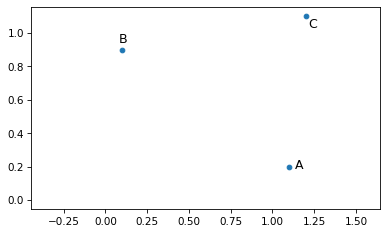

In [7]:
scatter([A, B, C], s=20)
plot_vector(A, label='A', alpha=0)
plot_vector(B, label='B', alpha=0)
plot_vector(C, label='C', label_pos=1, alpha=0, color='C1')
plt.axis('equal');

It is more common to represent vectors with an arrow with its tail at the origin.

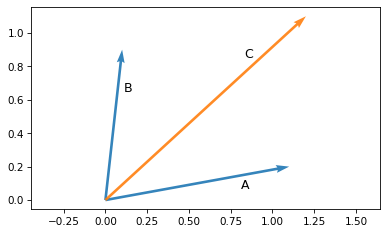

In [8]:
plot_vector(A, label='A', label_pos=2)
plot_vector(B, label='B', label_pos=2)
plot_vector(C, label='C', label_pos=10, color='C1')
plt.axis('equal');

But it's not necessary to put the tail at the origin.
For example, we could put the tail of `B` at the head of `A`.

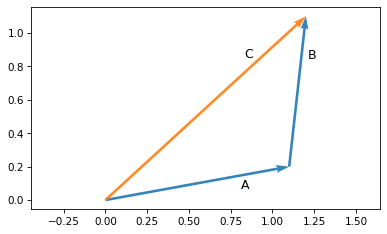

In [9]:
plot_vector(A, label='A', label_pos=2)
plot_vector(C, label='C', label_pos=10, color='C1')
plot_vector(B, origin=A, label='B', label_pos=2)
plt.axis('equal');

In this arrangement we can see that adding vectors is like lining them up head to tail.
If we start from the origin and follow `A`, then continue from `A` and follow `B`, we arrive at their sum, `C`.

To compute the difference between two vectors, we can subtract the coordinates elementwise.

In [10]:
D = B - A
D

array([-1. ,  0.7])

If we plot the result, `D`, with its tail at `A`, we get a graphical representation of subtraction.
And if we follow the arrows, we can see the inverse operation -- the sum of `A` and `D` is `B`.

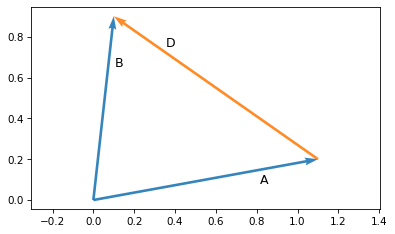

In [11]:
plot_vector(A, label='A', label_pos=2)
plot_vector(B, label='B', label_pos=2)
plot_vector(D, origin=A, label='D', label_pos=2, color='C1')
plt.axis('equal');

Now let's see an exampl where this is useful -- analysis of GPS data.

## GPS Data

To prepare for this chapter, I went to a location near my home and went for a short run wearing a watch that tracked my location using the Global Positioning System (GPS).
I downloaded the results as a GPX file, which is a standard format for storing GPS tracks.

We'll use the `gpxpy` library to parse the file and extract the data points.

In [12]:
import gpxpy

def load_gpx(filename):
    """Load a GPX file and return a DataFrame with lat, lon, elevation, and time."""
    with open(filename, "r") as f:
        gpx = gpxpy.parse(f)

    records = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                records.append({
                    "time": point.time,
                    "latitude": point.latitude,
                    "longitude": point.longitude,
                    "elevation": point.elevation,
                })

    return pd.DataFrame(records)

In [13]:
df_all = load_gpx("oval_run.gpx")
df_all.shape

(59, 4)

The result is a Pandas `DataFrame` with one row for each GPS measurement and columns that record the time of each measurement, my latitude, longitude, and altitude.

For this analysis, we'll select a segment of the run starting from the 34th measurement.

In [14]:
df = df_all.iloc[34:].reset_index(drop=True)

Here are the first few measurements.

In [15]:
df.head()

,time,latitude,longitude,elevation
0,2025-11-16 16:11:18+00:00,42.2936,-71.2636,59.7000
1,2025-11-16 16:11:19+00:00,42.2936,-71.2636,59.7000
2,2025-11-16 16:11:20+00:00,42.2937,-71.2636,59.7000
3,2025-11-16 16:11:22+00:00,42.2937,-71.2637,59.8000
4,2025-11-16 16:11:23+00:00,42.2937,-71.2637,59.8000


In [16]:
lats, lons = df['latitude'], df['longitude']

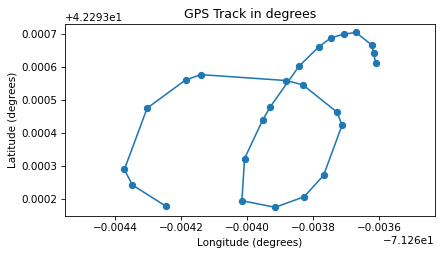

In [17]:
plt.plot(lons, lats, marker="o")

plt.axis("equal")
decorate(xlabel='Longitude (degrees)', ylabel='Latitude (degrees)', 
         title='GPS Track in degrees')

If you are curious, you can probably figure out where I ran.

This plot shows the path, but working directly with latitude and longitude has some drawbacks: the units are in degrees rather than meters, and the relationship between these coordinates and actual distances depends on where you are on Earth.
But with a little geometry, we can convert latitude and longitude to distances in meters.

## Haversine Function

The key idea is to convert each latitude-longitude pair to a unit vector in 3D Cartesian coordinates.
Then we can use the dot product to find the angle between the vectors, and multiply by Earth's radius to get the distance.

As an example, let's extract the start and end points from the GPS track.
First we'll convert the track to an array of lat-lon pairs.

In [62]:
cols = ['latitude', 'longitude']
latlon = df[cols].values

Then we'll select the first and last.

In [63]:
start = latlon[0]
start

array([ 42.2936, -71.2636])

In [64]:
end = latlon[-1]
end

array([ 42.2932, -71.2642])

We'll use the following function to convert latitude and longitude (in degrees) to spherical coordinates -- that is, azimuth and elevation in radians -- and then to 3D Cartesian coordinates.

In [75]:
from utils import sph2cart

def latlon_to_cartesian(lat, lon, radius=1.0):
    """
    Convert latitude and longitude (in degrees) to Cartesian coordinates.
    
    Parameters
    ----------
    lat : float or array_like
        Geodetic latitude in degrees (north positive).
    lon : float or array_like
        Longitude in degrees (east positive).
    radius : float or array_like, optional
        Radius of the sphere. Default is 1.0 for unit vectors.
    
    Returns
    -------
    xyz : ndarray of shape (3,) or (N, 3)
        Cartesian coordinates [x, y, z] in an Earth-centered, Earth-fixed frame.
    """
    return sph2cart(np.deg2rad(lon), np.deg2rad(lat), radius)

Now we can convert our start and end points to unit vectors:

In [76]:
start_vec = latlon_to_cartesian(start[0], start[1])
start_vec

array([ 0.2376, -0.7005,  0.6729])

In [77]:
end_vec = latlon_to_cartesian(end[0], end[1])
end_vec

array([ 0.2376, -0.7005,  0.6729])

Since these are unit vectors, their dot product gives us the cosine of the angle between them:

In [78]:
cos_angle = np.dot(start_vec, end_vec)
cos_angle

1.0000

From the dot product, we can compute the angle in radians:

In [79]:
angle_rad = np.arccos(cos_angle)
angle_rad

0.0000

Now we need Earth's radius to convert the angle to distance.
We'll use the mean radius of Earth (approximately 6,371,000 meters):

In [80]:
R_earth = 6_371_000 # meters
distance = R_earth * angle_rad
distance

71.3684

This gives us the great-circle distance between the two points.

The `haversine` library provides a function that does the same thing.

In [81]:
from haversine import haversine, Unit

haversine_distance = haversine(start, end, unit=Unit.METERS)
haversine_distance

71.3684

The results are close by not exactly the same.
Computing the inverse cosine of a small angle is not precise, numerically.
The `haversine` library uses another method that is mathematically the same, but numerically more precise.

In [82]:
haversine_distance - distance

0.0001

Note that this method treats the Earth as a perfect sphere, which is only approximately true.
There are other methods that account for differences in the radius of the earth at different locations, but for this example we'll keep it simple.

## Converting Coordinates

Now that we have the Haversine function, we can use it to convert lat-lon pairs to Cartesian coordinates in meters.
To start, we'll compute the mean of the lat-lon pairs.

In [25]:
latlon_mean = latlon.mean(axis=0)
latlon_mean

array([ 42.2935, -71.2639])

Now we can compute the offset of each point from the center.

In [26]:
latlon_offset = latlon - latlon_mean
latlon_offset[:5]

array([[0.0001, 0.0003],
       [0.0002, 0.0003],
       [0.0002, 0.0003],
       [0.0002, 0.0002],
       [0.0002, 0.0002]])

These offsets are in degrees.
To convert them to meters, we need to know how many meters correspond to one degree of latitude and longitude at our location.

We can use the haversine formula to compute this.
Starting from the mean position, we'll compute the distance to a point one degree to the east.

In [27]:
lat_mean, lon_mean = latlon_mean

north = [lat_mean + 1, lon_mean]
meters_per_degree_lat = haversine(latlon_mean, north, unit=Unit.METERS)
meters_per_degree_lat

111195.0802

And the distance to a point one degree north.

In [28]:
east = [lat_mean, lon_mean + 1]
meters_per_degree_lon = haversine(latlon_mean, east, unit=Unit.METERS)
meters_per_degree_lon

82251.3984

We'll put these conversion factors in an array we'll use as a scaling vector.

In [29]:
meters_per_degree = np.array([meters_per_degree_lat, meters_per_degree_lon])
meters_per_degree

array([111195.0802,  82251.3984])

And multiply each offset by this scaling factor to get positions in meters.

In [30]:
latlon_meters = latlon_offset * meters_per_degree
latlon_meters[:5]

array([[16.2167, 24.7149],
       [19.5525, 24.2214],
       [22.2212, 23.7279],
       [26.4466, 19.8621],
       [25.8907, 16.8188]])

In this example, we assume that meters per degree is the same at all positions in the track.
That's a good enough approximation over short distances, but for longer distances -- like a plane flight -- it would not be accurate.

As the last step, we have to reverse the order of the columns -- because latitude corresponds to the `x` coordinate and longitude corresponds to the `y` coordinate.

In [31]:
position = np.fliplr(latlon_meters)
position[:5]

array([[24.7149, 16.2167],
       [24.2214, 19.5525],
       [23.7279, 22.2212],
       [19.8621, 26.4466],
       [16.8188, 25.8907]])

Let's plot the result.

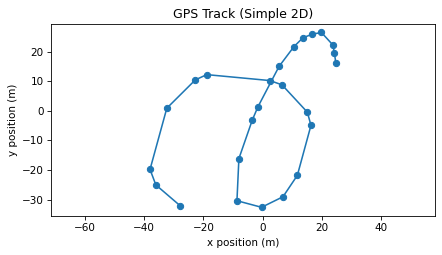

In [32]:
xs, ys = position.T
plt.plot(xs, ys, 'o-')
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)",
         title="GPS Track in meters")

After all that, the track in meters doesn't look very different from the track in degrees of longitude and latitude.
But now that it is expressed in meters, we can use it to compute velocity in meters per second -- which is more comprehensible than degrees per second.


## Position and Velocity

Now that we have our GPS data in a coordinate system with units of meters, we can use it to explore vector calculus.
We'll compute velocity and acceleration vectors from the position measurements.

We'll use the simpler 2D conversion (`position_2d`) for our vector calculus analysis.
Each position is a 2D vector with x and y components in meters.

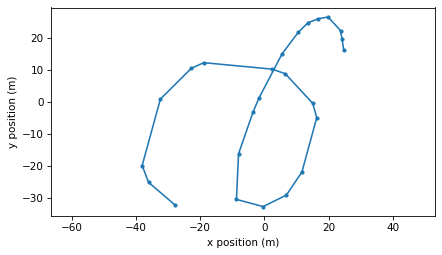

In [33]:
xs, ys = position.T
plt.plot(xs, ys, ".-")
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

## Visualizing Vectors

To make it easier to visualize vectors, we'll use helper functions from `utils`.
The `scatter` function plots points from an array of position vectors.

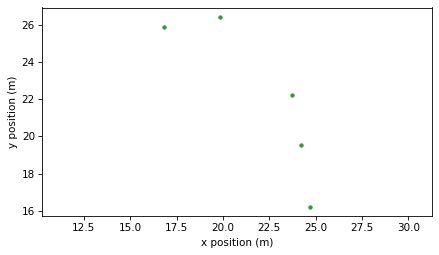

In [34]:
scatter(position, end=5, s=10, color="C2")
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

The `plot_vectors` function plots vectors as arrows, optionally with specified origin points.
We can use it to plot position vectors from the origin.

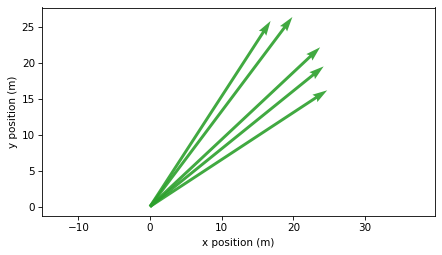

In [35]:
plot_vectors(position, end=5, color="C2")
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

## Differentiation: From Position to Velocity

Velocity is the rate of change of position.
With discrete data, we compute differences between consecutive positions and divide by the time intervals.
This is the discrete approximation to the derivative.

First, we need to extract the time data and compute the time intervals between measurements.

In [36]:
times = pd.to_datetime(df["time"])
time_seconds = (times - times.iloc[0]).dt.total_seconds().values
dts = np.diff(time_seconds)
dts[:5]

array([1., 1., 2., 1., 1.])

Now we can compute velocity by dividing position differences by time differences.

In [37]:
velocity = np.diff(position, axis=0) / dts[:, None]
velocity.shape

(24, 2)

We can plot velocity vectors at their corresponding positions.
The velocity vectors are tangent to the curve.

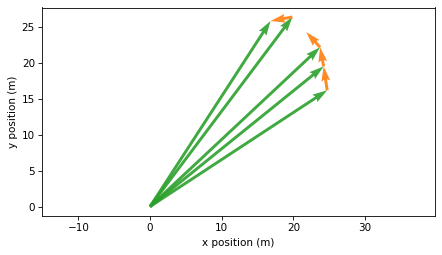

In [38]:
plot_vectors(position, end=5, color="C2")
plot_vectors(velocity, position, end=4, color="C1")
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

Or we can plot velocity vectors in velocity space, showing how velocity changes over time.

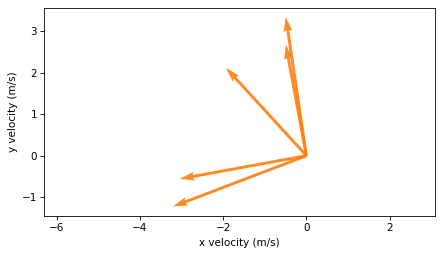

In [39]:
plot_vectors(velocity, end=5, color="C1")
plt.axis("equal")
decorate(xlabel="x velocity (m/s)", ylabel="y velocity (m/s)")

The magnitude of each velocity vector is the speed.
We can compute this using the norm (length) of each vector.

In [40]:
from numpy.linalg import norm

speeds = [norm(vector) for vector in velocity]

More efficiently, we can compute all norms at once by specifying `axis=1`.

In [41]:
speeds = norm(velocity, axis=1)
speeds.shape

(24,)

Let's plot the speed over time.

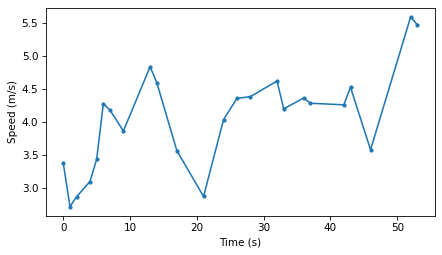

In [42]:
plt.plot(time_seconds[:-1], speeds, ".-")
decorate(xlabel="Time (s)", ylabel="Speed (m/s)")

## Differentiation Again: From Velocity to Acceleration

Acceleration is the rate of change of velocity.
We compute it the same way: differences between consecutive velocities divided by time intervals.

In [43]:
acceleration = np.diff(velocity, axis=0) / dts[1:, None]

We can plot acceleration vectors at their corresponding positions.
Note that we scale the acceleration by 10 to make it visible -- acceleration magnitudes are much smaller than velocities.

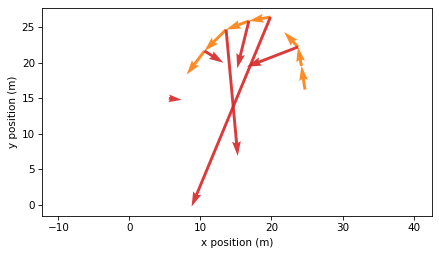

In [44]:
end = 7
plot_vectors(velocity, position, end=end, color="C1")
plot_vectors(acceleration * 10, position[1:], start=1, end=end, color="C3")
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

Or we can plot how acceleration changes in velocity space.

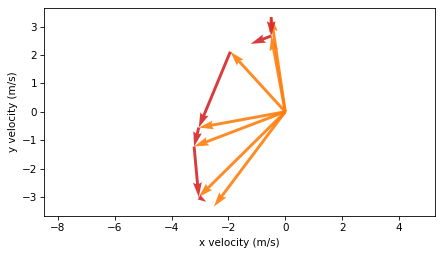

In [45]:
plot_vectors(velocity, end=7, color="C1")
plot_vectors(acceleration, velocity, end=6, color="C3")
plt.axis("equal")
decorate(xlabel="x velocity (m/s)", ylabel="y velocity (m/s)")

The acceleration vectors point toward the center of the curve, which is characteristic of **centripetal acceleration** -- the acceleration needed to make an object follow a curved path.


## Vector Integration

<!-- #region -->
We've seen how differentiation converts position to velocity.
Now let's go the other direction: integration converts velocity back to displacement.

In calculus, integration is the inverse of differentiation.
With discrete data, integration means adding up small changes.
Each velocity vector represents a rate of change, and when we multiply it by a time interval, we get a displacement for that interval.

Let's demonstrate this by computing the total displacement from start to finish.

In [46]:
A = position[0]
C = position[-1]

The vector from `A` to `C` is the direct displacement from start to end.

In [47]:
direct_displacement = C - A
direct_displacement

array([-52.4764, -48.3699])

Now let's compute the same displacement by integrating velocity.
We multiply each velocity by its time interval and sum all the results.

In [48]:
displacement_from_velocity = np.sum(velocity * dts[:, None], axis=0)
displacement_from_velocity

array([-52.4764, -48.3699])

Let's visualize both displacements.

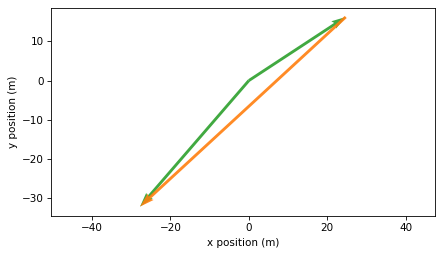

In [49]:
plot_vectors([A, C], color="C2")
plot_vectors([displacement_from_velocity], [A], color="C1")

plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

The two vectors should be nearly identical, confirming that:

$$\text{displacement} = \int \text{velocity} \, dt \approx \sum \text{velocity} \times \Delta t$$

This demonstrates the fundamental theorem of calculus with vectors: integration (summing velocity × dt) gives us back the net change in position.

Let's also look at a shorter segment to see how individual velocity vectors add up.

In [50]:
A = position[3]
C = position[4]
B = C - A

The displacement `B` from position 3 to position 4 can be visualized as a single vector.

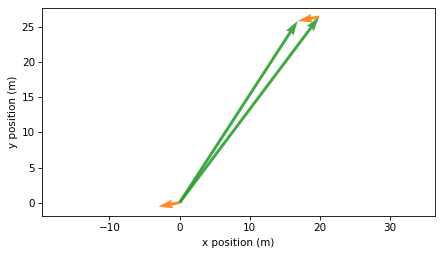

In [51]:
plot_vectors([A, C], color="C2")
plot_vectors([B], color="C1")
plot_vectors([B], [A], color="C1")

plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

Vector `B` appears twice: once at the origin and once at position `A`.
This illustrates that displacement vectors can be moved -- what matters is their magnitude and direction, not where they start.
This is the key property that makes vector addition work: we can place vectors tail-to-head and add them up to get the net displacement.



## 3D Coordinate Transformations

The simple 2D conversion works well for most applications, but it's also interesting to see how GPS coordinates relate to 3D geometry.
In this section, we'll convert from latitude-longitude-elevation to a local Cartesian coordinate system using vectors from Earth's center.

This approach is more complex than necessary for practical use, but it demonstrates important concepts in linear algebra: coordinate systems, basis vectors, and projection matrices.

First, we need to account for the fact that Earth is not a perfect sphere.
The following function computes the radius of Earth at a given latitude, taking into account that Earth is slightly flattened at the poles.
<!-- #endregion -->

In [52]:
def earth_radius(lat_deg):
    a = 6378137.0          # equatorial radius (m)
    b = 6356752.3          # polar radius (m)
    lat = np.deg2rad(lat_deg)
    return np.sqrt(
        ((a**2 * np.cos(lat))**2 + (b**2 * np.sin(lat))**2) /
        ((a * np.cos(lat))**2 + (b * np.sin(lat))**2)
    )

We'll compute the average radius for our track location.

In [53]:
lat = df['latitude'].mean()
R = earth_radius(lat)
lat, R

(42.2935, 6368497.7855)

The result shows the average latitude of our track and the corresponding radius in meters.

Now we'll convert latitude, longitude, and elevation to 3D Cartesian coordinates in an Earth-centered reference frame.
This is a standard transformation used in geodesy.

In [54]:
def latlon_to_cartesian(lat_deg, lon_deg, radius=1.0):
    """
    Convert latitude and longitude (in degrees) to Cartesian coordinates.

    Parameters
    ----------
    lat_deg : array_like
        Geodetic latitude in degrees (north positive).
    lon_deg : array_like
        Longitude in degrees (east positive).
    radius : float or array_like, optional
        Radius of the sphere. Default is 1.0 for unit vectors.

    Returns
    -------
    xyz : ndarray of shape (N, 3)
        Cartesian coordinates [x, y, z] in an Earth-centered, Earth-fixed frame.

    Notes
    -----
    - The coordinate frame is right-handed:
        +x → (lat=0°, lon=0°)
        +y → (lat=0°, lon=90°E)
        +z → (North Pole)
    - This is the standard spherical-to-Cartesian conversion used for
      geocentric coordinates (no ellipsoid flattening applied).
    """
    lat = np.deg2rad(lat_deg)
    lon = np.deg2rad(lon_deg)
    return sph2cart(lon, lat, radius)

We extract the latitude, longitude, and elevation from the DataFrame, and add the elevation to Earth's radius.

In [55]:
lat, lon, elev = df[["latitude", "longitude", "elevation"]].values.T
R + elev

array([6368557.4855, 6368557.4855, 6368557.4855, 6368557.5855,
       6368557.5855, 6368557.5855, 6368557.3855, 6368557.0855,
       6368556.9855, 6368556.9855, 6368556.9855, 6368556.9855,
       6368556.8855, 6368556.7855, 6368556.6855, 6368556.8855,
       6368556.9855, 6368556.9855, 6368556.9855, 6368558.0855,
       6368558.0855, 6368557.7855, 6368557.3855, 6368557.2855,
       6368557.1855])

Now we can convert all the GPS points to 3D Cartesian coordinates.
Each point is represented as a vector from the center of Earth.

In [56]:
r = latlon_to_cartesian(lat, lon, R + elev)

We'll compute the mean position, which gives us a reference point near the center of our track.

In [57]:
r0 = r.mean(axis=0)
r0

array([445858.3361, 445859.4178, 445860.2415, 445860.2492, 445858.7482,
       445856.9195, 445854.4582, 445849.7364, 445841.4154, 445838.8956,
       445831.9518, 445826.1685, 445828.8118, 445833.2398, 445838.0792,
       445846.577 , 445847.783 , 445847.738 , 445846.5592, 445838.4082,
       445836.0864, 445828.3   , 445817.8739, 445816.6796, 445817.4305])

And we can normalize this vector to get a unit vector in the radial direction.

In [58]:
from utils import norm, normalize

r_hat = normalize(r0)
r_hat

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

## Creating a Local Coordinate System

For our analysis, we need a local coordinate system with axes that are East, North, and Up relative to our location on Earth.
We'll use the cross product to create these basis vectors.

The cross product of two vectors produces a third vector that is perpendicular to both.
We'll start by crossing the global "up" direction (north pole) with our radial vector to get an "east" direction.

In [59]:
# local basis via vector operations
z_hat = np.array([0, 0, 1])
e = np.cross(z_hat, r0)
e_hat = normalize(e)
norm(e_hat)

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

Now we can use another cross product to get the "north" direction, which is perpendicular to both the radial and east directions.

In [ ]:
n_hat = np.cross(r_hat, e_hat)
norm(n_hat)

The result confirms that we have three orthonormal basis vectors: east (`e_hat`), north (`n_hat`), and radial (`r_hat`).

To visualize these coordinate systems, we'll draw a 3D globe with our local basis vectors.

In [ ]:
import numpy as np

def draw_globe(ax, R=3.0, n_lat=9, n_lon=12, alpha=0.3):
    """Draw a globe of radius R with lines of latitude and longitude.
    """
    # ---- base surface ----
    lat_grid = np.linspace(-90, 90, 60)
    lon_grid = np.linspace(-180, 180, 120)
    lat, lon = np.meshgrid(lat_grid, lon_grid)
    xyz = latlon_to_cartesian(lat.ravel(), lon.ravel(), radius=np.full(lat.size, R))
    X, Y, Z = [a.reshape(lat.shape) for a in xyz.T]
    ax.plot_surface(X, Y, Z, color='C0', alpha=0.04, linewidth=0)

    # ---- latitude circles ----
    lats = np.linspace(-60, 60, n_lat)
    lons = np.linspace(-180, 180, 361)
    for lat in lats:
        xyz = latlon_to_cartesian(np.full_like(lons, lat), lons, radius=np.full_like(lons, R))
        ax.plot(*xyz.T, color='k', linewidth=0.5, alpha=alpha)

    # ---- longitude lines ----
    lons = np.linspace(-180, 180, n_lon, endpoint=False)
    lats = np.linspace(-90, 90, 181)
    for lon in lons:
        xyz = latlon_to_cartesian(lats, np.full_like(lats, lon), radius=np.full_like(lats, R))
        ax.plot(*xyz.T, color='k', linewidth=0.5, alpha=alpha)


In [ ]:
from utils import setup_3D


def globe_diagram(R):
    fig, [ax] = setup_3D(show_grid=False)
    ax.view_init(elev=20, azim=-45, roll=0)

    draw_globe(ax, R)

    lim = [-6, 6]
    decorate(xlim=lim, ylim=lim, zlim=lim, 
             xlabel='i', ylabel='j', zlabel='k', 
             aspect='equal')

For visualization, we'll scale down the radius by a factor of a million so the vectors fit on the same scale as the globe.

In [ ]:
r0_scaled = r0 / 1e6
R_scaled = norm(r0_scaled)
z_scaled = z_hat * R_scaled

Here's a 3D diagram showing the reference position vector and the plane used to compute the east direction.

In [ ]:
from utils import plot_vector_3D, plot_vectors_3D, label_vectors_3D, plot_plane

globe_diagram(R_scaled)

plot_vector_3D(r0_scaled, label='$r0$', color='C1', alpha=1)

plot_vector_3D(z_scaled, label='$\hat{z}$', color='C1', alpha=1)

plot_plane(r0_scaled, z_scaled, alpha=0.2)

plot_vector_3D(e_hat, label='$\hat{e}$', scale=5, alpha=1)

And here's a diagram showing all three basis vectors of our local coordinate system.

In [ ]:
globe_diagram(R_scaled)

plot_vectors_3D([r0_scaled, z_scaled], color='C1', alpha=1)

origins = [r0_scaled] * 3
plot_vectors_3D([r_hat, e_hat, n_hat], origins, scale=5, alpha=1)
label_vectors_3D(['$\hat{r}$', '$\hat{e}$', '$\hat{n}$'], 
                 [r_hat, e_hat, n_hat], origins, scale=5)

## Projecting to Local Coordinates

Now that we have a local coordinate system, we can transform all of our GPS points into this system.
We'll use a projection matrix whose columns are our basis vectors.

When we multiply a vector by this matrix, it computes the projections onto each basis vector, giving us coordinates in meters relative to our reference point.

In [ ]:
# projection matrix
T = np.column_stack([e_hat, n_hat, r0])

# local coords (in meters)
d = r - r0
enr = d @ T
df["east_m"], df["north_m"], df["up_m"] = enr.T

Now we can plot the track in our local coordinate system, with axes in meters.

In [ ]:
plt.plot(df["east_m"], df["north_m"], marker=".", lw=0)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("GPS Track")
plt.axis("equal");

This plot looks similar to the lat-lon plot, but now the coordinates are in meters and represent actual distances.

We can verify this by computing the distance from start to finish in the local coordinate system.

In [ ]:
cols = ["east_m", "north_m"]
start = df.loc[0, cols]
end = df.loc[df.index[-1], cols]
v = end - start
np.linalg.norm(v)

This should match the haversine distance we computed earlier.





[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [ ]:
from traffic.data import opensky

opensky.username = "allendowney"
opensky.password = "yZ6j8T9H"


In [ ]:
from traffic.data import airports
from traffic.core import Flight
import pandas as pd

bos = airports["KBOS"]
dub = airports["EIDW"]

# Query flights on a given date
flights = opensky.history(
    start="2025-06-01 00:00",
    stop="2025-06-02 00:00",
    departure_airport=bos,
    arrival_airport=dub,
)

flights
